In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from scipy.signal import find_peaks
import ruptures as rpt
import time
import math
from scipy import ndimage as ndi
import plotly.io as pio
from numba import njit
from numba import jit, prange
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

In [112]:
# загрузка данных 
start_time = time.time()
run_0 = pd.read_csv(r'D:/DATA/DataR_CH0@V1725B_372_run1_Th228_14400s.csv', nrows=100000)
end_time = time.time()
print(end_time - start_time)
# , usecols=range(3000)

65.82598114013672


In [113]:
# Нахождение и удаление дорожек с перенасыщением

run_0['max_value'] = run_0.max(axis=1)
index_glut = run_0.query('max_value > 16000').index.tolist()
# px.line(run_0.iloc[index_glut[0]])
run_0 = run_0.drop(index=index_glut)
run_0.reset_index(drop= True , inplace= True)
run_0.drop(['max_value'], axis= 1 , inplace= True )
print('Удаленно строк:', len(index_glut))

Удаленно строк: 46


In [104]:
# Удаление перекосившихся сигналов

run_0['first_sample'] = run_0['0']
run_0['last_sample'] = run_0['4999']
index_falling_signal = run_0.query('first_sample > last_sample').index.tolist()
# px.line(run_0.iloc[index_falling_signal[0]])
run_0 = run_0.drop(index=index_falling_signal)
run_0.reset_index(drop= True , inplace= True)
run_0.drop(['first_sample', 'last_sample'], axis= 1 , inplace= True)
print('Удаленно строк:', len(index_falling_signal))

Удаленно строк: 411


In [64]:
def find_start_rise(row, num_next_values):
    differences = np.zeros_like(row)
    start_of_growth = 0  # Инициализация переменной внутри цикла
    value_at_start = row[start_of_growth]  # Инициализация переменной внутри цикла
    
    for i in range(len(row) - num_next_values):
        differences[i] = row[i + num_next_values] - row[i]
        start_of_growth = np.argmax(differences)
        value_at_start = row[start_of_growth]
    
    return pd.Series({
        'index_start_rise': start_of_growth,
        'value_start_rise': value_at_start,
    })

# start_time = time.time()

# data_rise = run_0.apply(find_start_rise, num_next_values=68, axis=1)

# finish_time = time.time()
# print(finish_time - start_time)

44.172109603881836


In [114]:
# Определение функции гауссиана
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)


def gaussian_fit(row, periods):
    
    center = int(row.diff(periods=periods).idxmax()) #индекс самого большого значения
    amplitude = row.diff(periods=periods)[center] #значение амлитуды
    sigma = 100
    
    y = row.diff(periods=periods)
    y = y.iloc[periods:]
    x = np.array([i for i in range(len(y))])

    # Подгонка данных с помощью curve_fit
    initial_guess = [amplitude, center, sigma]  # Начальные значения параметров
    params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)

    # Получение подогнанных значений
    y_fit = gaussian(x, *params)
    
    #Расчет начала подъема
    width_within_3_sigma = 2 * 3 * params[2] # Ширина в пределах 3σ
    index_start_rise = round(params[1] - (width_within_3_sigma / 2) + periods)
    value_start_rise = row.iloc[index_start_rise]
    
    # Расчет среднеквадратичной ошибки (MSE)
    mse = np.mean((y - y_fit)**2)
    
    # Расчет хи-квадрат
    residuals = y - y_fit
    chi_square = np.sum((residuals / np.sqrt(y_fit))**2)
    
    # Расчет Коэффициента корреляции (Pearson's r)
    r, _ = pearsonr(y, y_fit)

    # Расчет R-квадрат (R^2)
    ssr = np.sum((y - y_fit)**2)
    sst = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ssr / sst)


    return pd.Series({
        'index_start_rise': index_start_rise,
        'value_start_rise': value_start_rise,
        'amplitude': params[0],
        'center': params[1],
        'sigma': params[2],
        'chi_square': chi_square,
        'mse': mse,
        'pearson_r': r,
        'r_squared': r_squared
            })

start_time = time.time()

data_fit = run_0.apply(gaussian_fit, periods=68, axis=1)

finish_time = time.time()

print(finish_time - start_time)

In [116]:
# start_time = time.time()

# data_fit = run_0.apply(gaussian_fit, periods=68, axis=1)

# finish_time = time.time()

# print(finish_time - start_time)

In [209]:
# Определение функции гауссиана
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)

# Создание списка для сохранения результатов
bad_signal = []
data_fit = []
periods = 68  # Установите нужное значение periods
counter = 0

start_time = time.time()
# Перебираем каждую строку DataFrame
for index, row in run_0.iterrows():
#     row = row.iloc[:2500]
    counter += 1
    y = row.diff(periods=periods)
    threshold = (np.max(y) - np.min(y))/2 + np.min(y)
    peaks, _ = find_peaks(y, height=threshold, distance=150)
    
    if len(peaks) >= 2:
        index_bad_signal = index
        bad_signal.append({
        'index_bad_signal': index
        })
    else:
        
        
        center = int(row.diff(periods=periods).idxmax()) #индекс самого большого значения
        amplitude = row.diff(periods=periods)[center] #значение амплитуды
        sigma = 100
    
        y = y.iloc[periods:]
        x = np.array([i for i in range(len(y))])

        # Подгонка данных с помощью curve_fit
        initial_guess = [amplitude, center, sigma]  # Начальные значения параметров
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess, maxfev = 5000)

        # Получение подогнанных значений
        y_fit = gaussian(x, *params)
    
        #Расчет начала подъема
        width_within_3_sigma = 2 * 3 * params[2] # Ширина в пределах 3σ
        index_start_rise = round(params[1] - (width_within_3_sigma / 2) + periods)
        value_start_rise = row.iloc[index_start_rise]
    
        # Расчет среднеквадратичной ошибки (MSE)
        mse = np.mean((y - y_fit)**2)
    
        # Расчет хи-квадрат
        residuals = y - y_fit
        chi_square = np.sum((residuals / np.sqrt(y_fit))**2)
    
        # Расчет Коэффициента корреляции (Pearson's r)
        r, _ = pearsonr(y, y_fit)

        # Расчет R-квадрат (R^2)
        ssr = np.sum((y - y_fit)**2)
        sst = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ssr / sst)

        # Добавление результатов в список
        data_fit.append({
        'index_start_rise': index_start_rise,
        'value_start_rise': value_start_rise,
        'amplitude': params[0],
        'center': params[1],
        'sigma': params[2],
        'chi_square': chi_square,
        'mse': mse,
        'pearson_r': r,
        'r_squared': r_squared
    })

# # Создание DataFrame из списка результатов
# data_fit = pd.DataFrame(data_fit)

# Рассчитываем время выполнения
finish_time = time.time()
print(finish_time - start_time)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

In [210]:
counter

49519

In [125]:
data_fit = pd.DataFrame(data_fit)
data_fit

index_start_rise  value_start_rise   amplitude      center      sigma  \
0                  404              9857   62.790560  413.637835  25.881334   
1                  402              9876  564.610402  413.680328  26.667430   
2                  401              9854  183.668234  413.891424  27.066195   
3                  402              9882  688.671154  414.381856  26.670918   
4                  391              9852  413.682806  408.990313  28.738834   
...                ...               ...         ...         ...        ...   
2995               403              9850   60.079515  415.172611  26.870368   
2996               403              9852   57.967986  412.228947  25.908375   
2997               400              9856   49.677276  413.100427  26.953040   
2998               400              9851   51.532173  413.931321  27.462818   
2999               401              9855   57.789074  413.347152  26.910317   

      chi_square         mse  pearson_r  r_squared  
0            inf    8.359846   0.902311   0.812904  
1            inf   77.301911   0.988241   0.975082  
2            inf   12.137918   0.982658   0.963988  
3            inf  113.819151   0.988374   0.975337  
4            inf   25.586710   0.993627   0.985580  
...          ...         ...        ...        ...  
2995         inf    8.825609   0.892994   0.796283  
2996         inf    8.926785   0.881863   0.776401  
2997         inf    8.354872   0.860264   0.738998  
2998         inf    8.109528   0.873634   0.761906  
2999         inf    8.490512   0.889653   0.790197  

[3000 rows x 9 columns]

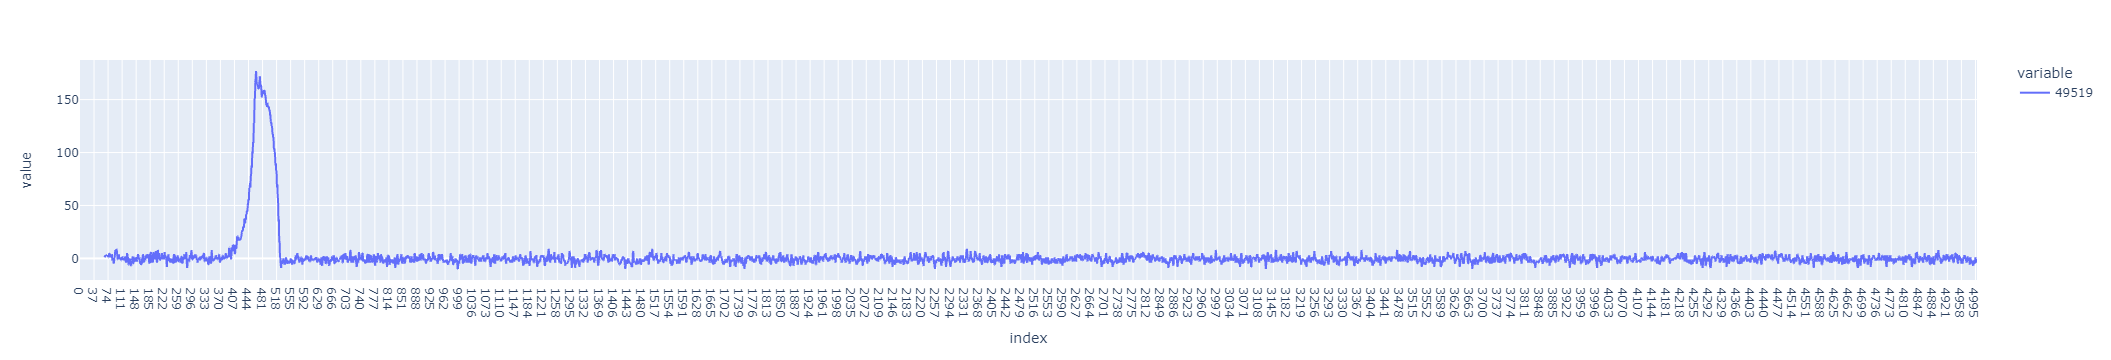

In [208]:
px.line(run_0.iloc[49519].diff(periods=65))

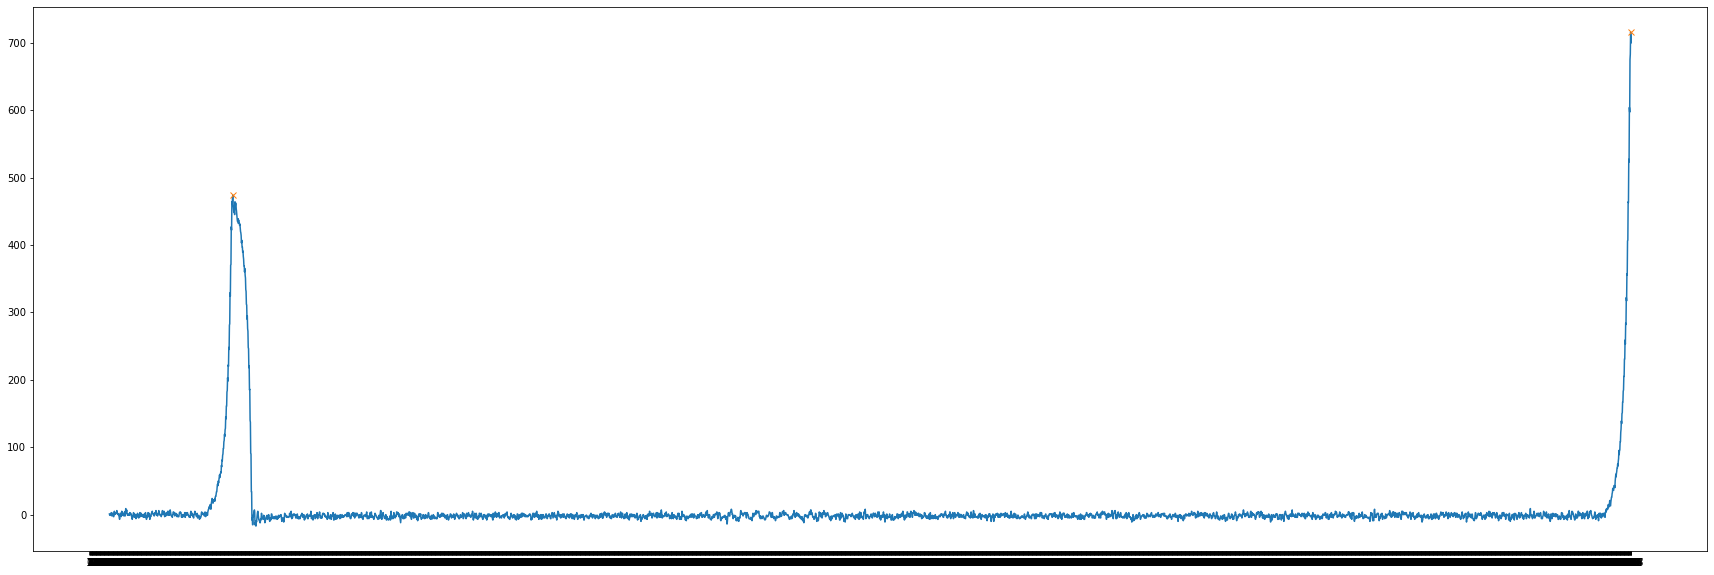

In [183]:
from scipy.signal import find_peaks

x = run_0.iloc[16524][:4999].diff(periods=65)
threshold = (np.max(x) - np.min(x))/2 + np.min(x)
peaks, _ = find_peaks(x, height=threshold, distance=150)


plt.figure(figsize=(30, 10))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")

plt.show()


In [185]:
len(peaks)

2

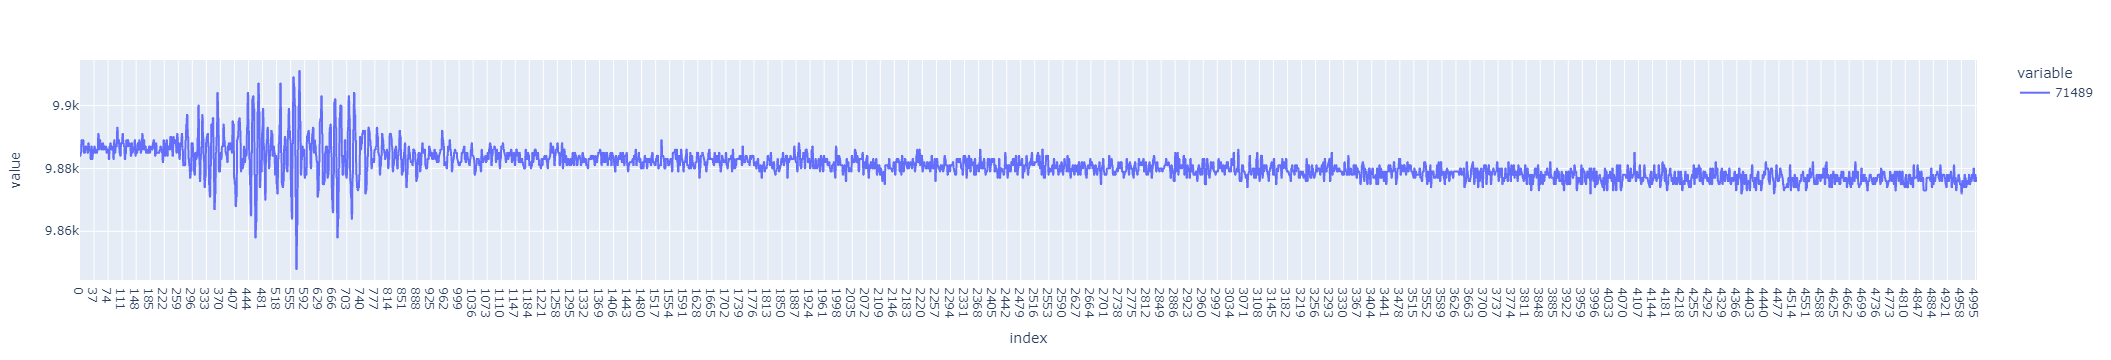

In [161]:
px.line(run_0.iloc[71489])

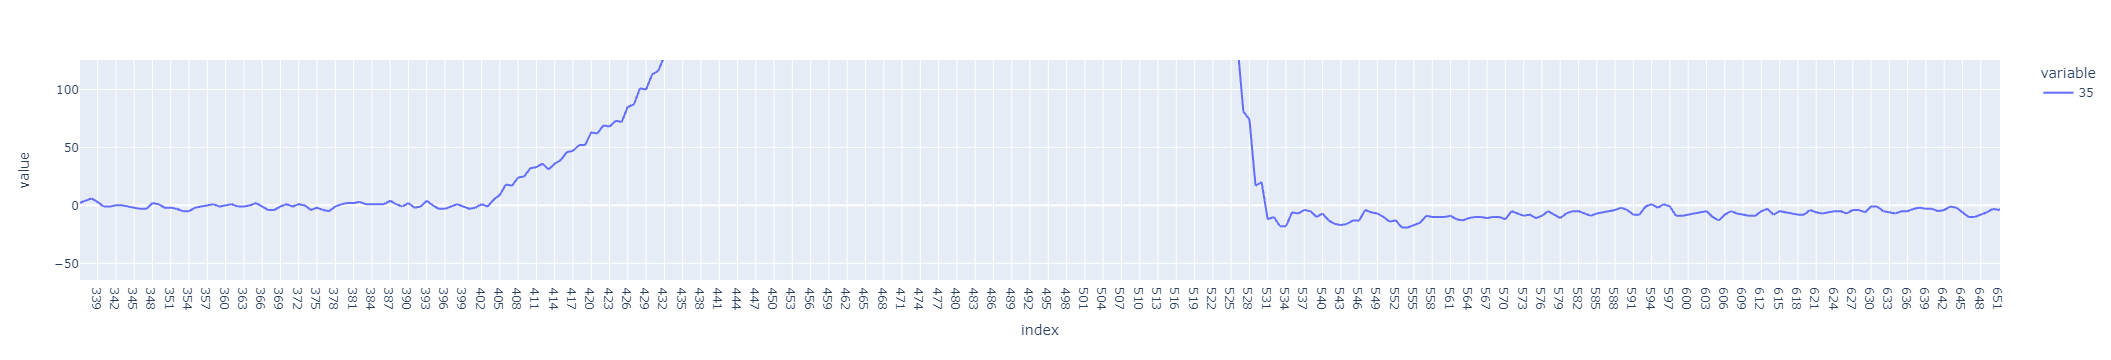

In [186]:
px.line(run_0.iloc[35].diff(periods=65))

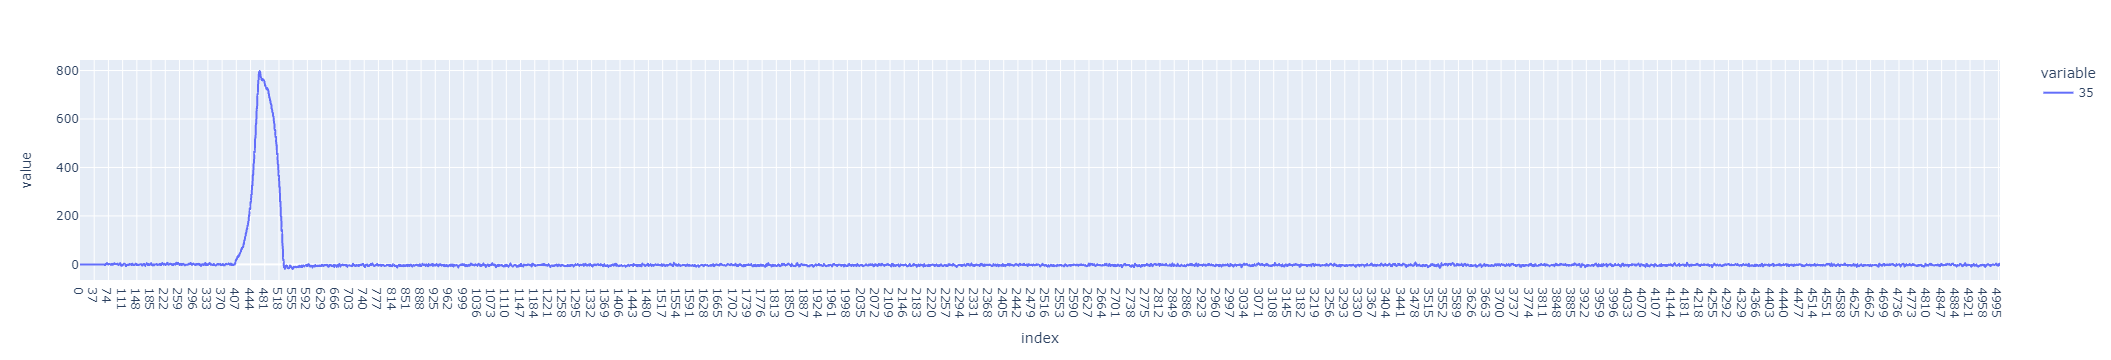

In [198]:
px.line(y_noisy)

Амплитуда: 506.76795340616854
Центр: 415.5899592210833
Сигма: 26.10754989990639


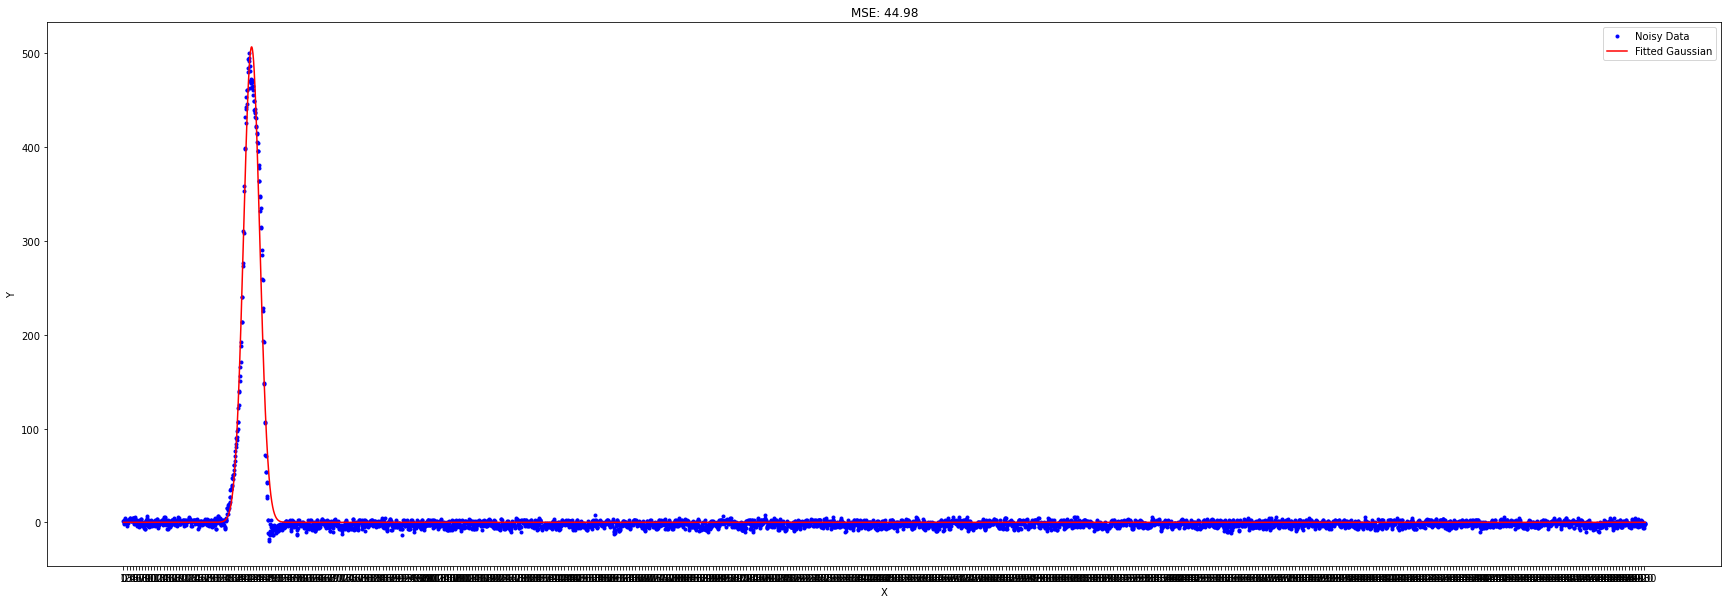

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

y_noisy = run_0.iloc[49322].diff(periods=65)
y_noisy = y_noisy.iloc[65:]
x = np.array([i for i in range(len(y_noisy))])


# Определение функции гауссиана
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)


# Подгонка данных с помощью curve_fit
initial_guess = [800, 420, 100]  # Начальные значения параметров
params, covariance = curve_fit(gaussian, x, y_noisy, p0=initial_guess)

# Получение подогнанных значений
y_fit = gaussian(x, *params)

# Расчет среднеквадратичной ошибки (MSE)
mse = np.mean((y_noisy - y_fit)**2)

# Расчет хи-квадрат
residuals = y_noisy - y_fit
# Расчет хи-квадрат
chi_square = np.sum((residuals - y_fit)**2 / y_fit)


print('Амплитуда:', params[0])
print('Центр:', params[1])
print('Сигма:', params[2])

# Определение значений для оси X
x_ticks = np.arange(min(x), max(x)+1, 10)  # Пример: шаг 10 между значениями

# Визуализация результатов с заданными значениями на оси X
plt.figure(figsize=(30, 10))
plt.plot(x, y_noisy, 'b.', label='Noisy Data')
#plt.plot(x, y_true, 'g', label='True Gaussian')
plt.plot(x, y_fit, 'r', label='Fitted Gaussian')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'MSE: {mse:.2f}')  # Вывод MSE на график
# Установка значений на оси X
plt.xticks(x_ticks)

plt.show()

In [48]:
sigma = 25.275026109321512  # Среднеквадратическое отклонение (σ)

width_within_3_sigma = 2 * 3 * sigma
print(f"Ширина в пределах 3σ: {width_within_3_sigma}")

(414.48865795298263 - 151.65015665592907 / 2) + 65

Ширина в пределах 3σ: 151.65015665592907


In [60]:
round((414.48865795298263 - 151.65015665592907 / 2) + 65)

404

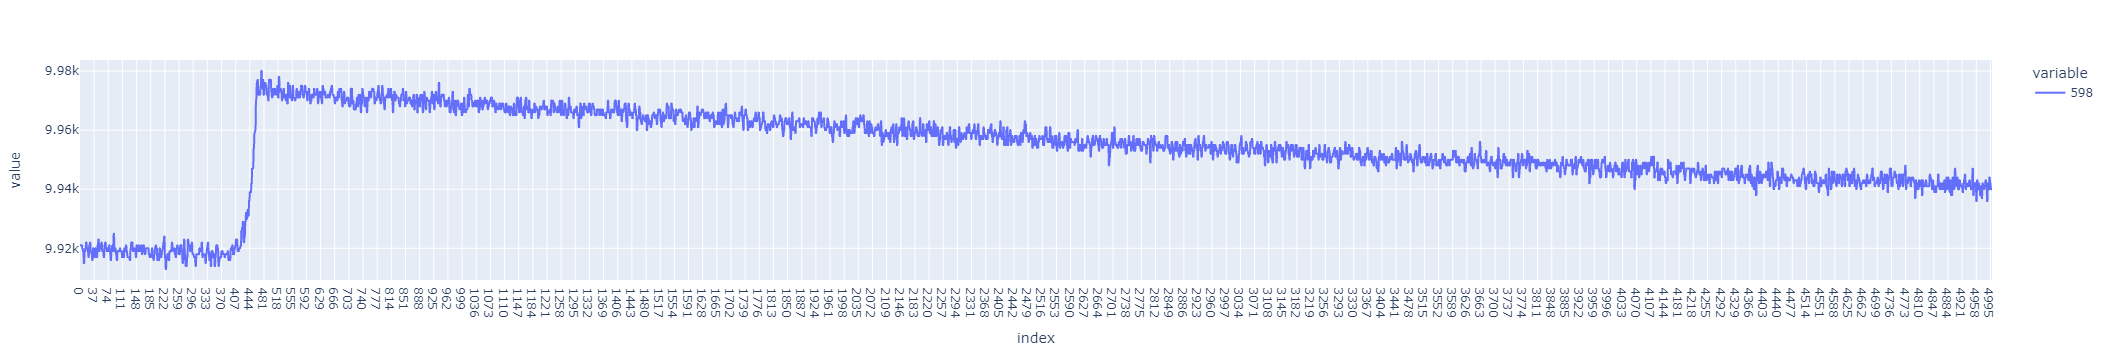

In [51]:
px.line(run_0.iloc[598])

In [195]:
def calculate_sigma(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

# Пример
fwhm = 25.539696283821012  # Пример полуширины (FWHM)
sigma = calculate_sigma(fwhm)
print(f"Среднеквадратическое отклонение (σ): {sigma}")

Среднеквадратическое отклонение (σ): 10.845710413292046


In [3]:
def calculate_fwhm(sigma):
    return 2 * np.sqrt(2 * np.log(2)) * sigma

# Пример
sigma = 25.53965594877319  # Среднеквадратическое отклонение (σ)
fwhm = calculate_fwhm(sigma)
print(f"Полная ширина распределения (FWHM): {fwhm}")


Полная ширина распределения (FWHM): 60.14129377136504


In [199]:
import numpy as np

# Известные параметры
sigma = 10.845710413292046  # Среднеквадратическое отклонение (σ)
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma  # Полуширина распределения (FWHM)

# Определение процента для начала и конца подъема (например, 5%)
percent = 0.02

# Определение значений, соответствующих началу и концу подъема
start_value = np.exp(-0.5 * (fwhm / (2 * sigma))**2 * (1 / percent))
end_value = np.exp(-0.5 * (fwhm / (2 * sigma))**2 * (1 - 1 / percent))

# Нахождение ширины между началом и концом подъема
rise_width = sigma * np.sqrt(-2 * np.log(start_value / end_value))

print(f"Ширина от начала подъема до конца: {rise_width}")


Ширина от начала подъема до конца: 127.05838474960268


In [201]:
end_value

562949953421311.44

In [197]:
# Известные параметры
amplitude = 813.6639379903507  # Амплитуда
sigma = 10.845710413292046       # Среднеквадратическое отклонение (σ)
mu = 481.1096884432452         # Среднее (центр) распределения

# Нахождение полной ширины Гауссовского распределения (FWHM)
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma

# Нахождение точек начала подъема и конца опускания
start_of_rise = mu - sigma * np.sqrt(2 * np.log(2))
end_of_drop = mu + sigma * np.sqrt(2 * np.log(2))

print(f"Полная ширина распределения (FWHM): {fwhm}")
print(f"Точка начала подъема: {start_of_rise}")
print(f"Точка конца опускания: {end_of_drop}")



Полная ширина распределения (FWHM): 25.539696283821012
Точка начала подъема: 468.3398403013347
Точка конца опускания: 493.87953658515573


In [29]:
sigma = 25.539696283821012  # Среднеквадратическое отклонение (σ)

width_within_3_sigma = 2 * 3 * sigma
print(f"Ширина в пределах 3σ: {width_within_3_sigma}")


Ширина в пределах 3σ: 153.23817770292607


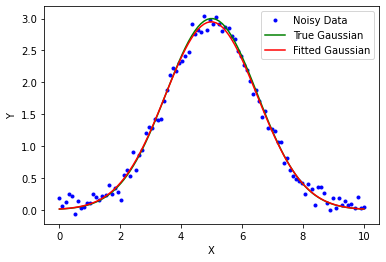

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Генерация зашумленных данных
np.random.seed(0)
x = np.linspace(0, 10, 100)
y_true = 3 * np.exp(-0.5 * ((x - 5) / 1.5)**2)
y_noisy = y_true + np.random.normal(0, 0.1, size=len(x))

# Определение функции гауссиана
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)

# Подгонка данных с помощью curve_fit
initial_guess = [1, 5, 1]  # Начальные значения параметров
params, covariance = curve_fit(gaussian, x, y_noisy, p0=initial_guess)

# Получение подогнанных значений
y_fit = gaussian(x, *params)

# Визуализация результатов
plt.plot(x, y_noisy, 'b.', label='Noisy Data')
plt.plot(x, y_true, 'g', label='True Gaussian')
plt.plot(x, y_fit, 'r', label='Fitted Gaussian')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [76]:
np.argmax(differences)

394

In [75]:
len(lst)

4932

In [59]:

differences = run_0.iloc[0].apply(lambda x: np.zeros(num_next_values) if isinstance(x, float) else pd.Series(np.zeros_like(x)))  # Создание массивов нулей для каждого элемента

In [60]:
differences

0
0     0
1     0
2     0
3     0
4     0
...  ..
4995  0
4996  0
4997  0
4998  0
4999  0

[5000 rows x 1 columns]

In [9]:
run_0

0     1     2     3     4     5     6     7     8     9  ...   4990  \
0      9853  9853  9851  9851  9848  9848  9855  9855  9857  9857  ...   9896   
1      9854  9854  9856  9856  9857  9857  9854  9854  9855  9855  ...  10252   
2      9855  9855  9854  9854  9852  9852  9854  9854  9852  9852  ...   9981   
3      9852  9852  9850  9850  9852  9852  9853  9853  9850  9850  ...  10331   
4      9852  9852  9853  9853  9854  9854  9851  9851  9851  9851  ...  10164   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
99995  9854  9854  9853  9853  9855  9855  9851  9851  9855  9855  ...   9967   
99996  9853  9853  9853  9853  9855  9855  9857  9857  9854  9854  ...  10291   
99997  9850  9850  9850  9850  9854  9854  9850  9850  9850  9850  ...   9893   
99998  9854  9854  9854  9854  9854  9854  9853  9853  9854  9854  ...   9893   
99999  9851  9851  9851  9851  9850  9850  9849  9849  9851  9851  ...   9984   

        4991   4992   4993   4994   4995   4996   4997   4998   4999  
0       9896   9897   9897   9895   9895   9896   9896   9897   9897  
1      10252  10254  10254  10253  10253  10253  10253  10255  10255  
2       9981   9980   9980   9985   9985   9986   9986   9985   9985  
3      10331  10333  10333  10334  10334  10332  10332  10335  10335  
4      10164  10164  10164  10168  10168  10167  10167  10166  10166  
...      ...    ...    ...    ...    ...    ...    ...    ...    ...  
99995   9967   9969   9969   9967   9967   9967   9967   9967   9967  
99996  10291  10296  10296  10291  10291  10290  10290  10289  10289  
99997   9893   9894   9894   9893   9893   9890   9890   9894   9894  
99998   9893   9890   9890   9891   9891   9894   9894   9897   9897  
99999   9984   9986   9986   9985   9985   9985   9985   9984   9984  

[100000 rows x 5000 columns]

In [10]:
run_0['max_value'] = run_0.max(axis=1)
index_glut = run_0.query('max_value > 16000').index.tolist()
print('Удаленно строк:', len(index_glut))

Удаленно строк: 46


In [11]:
run_0 = run_0.drop(index=index_glut)
run_0.reset_index(drop= True , inplace= True)

In [12]:
run_0['first_sample'] = run_0['0']
run_0['last_sample'] = run_0['4999']
index_falling_signal = run_0.query('first_sample > last_sample').index.tolist()
run_0 = run_0.drop(index=index_falling_signal)
run_0.reset_index(drop= True , inplace= True)
print('Удаленно строк:', len(index_falling_signal))

Удаленно строк: 402


In [13]:
run_0.query('first_sample > last_sample')

0      1      2      3      4      5      6      7      8      9  \
616    10014  10014  10014  10014  10014  10014  10013  10013  10013  10013   
886    10005  10005  10005  10005  10009  10009  10009  10009  10011  10011   
927    10527  10527  10528  10528  10529  10529  10524  10524  10528  10528   
955    10795  10795  10792  10792  10798  10798  10791  10791  10791  10791   
1313   10366  10366  10367  10367  10366  10366  10365  10365  10365  10365   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
97882  10026  10026  10026  10026  10030  10030  10029  10029  10029  10029   
98096  10022  10022  10023  10023  10023  10023  10024  10024  10016  10016   
98415  10056  10056  10054  10054  10053  10053  10053  10053  10052  10052   
98441  10487  10487  10484  10484  10482  10482  10483  10483  10484  10484   
98823  10027  10027  10028  10028  10025  10025  10026  10026  10023  10023   

       ...   4993   4994   4995   4996   4997   4998   4999  max_value  \
616    ...  10007  10006  10006  10010  10010  10004  10004      10067   
886    ...  10008  10004  10004  10006  10006  10004  10004      10066   
927    ...  10458  10459  10459  10457  10457  10463  10463      10690   
955    ...  10613  10614  10614  10618  10618  10616  10616      10881   
1313   ...  10344  10343  10343  10347  10347  10346  10346      10536   
...    ...    ...    ...    ...    ...    ...    ...    ...        ...   
97882  ...  10022  10025  10025  10020  10020  10024  10024      10093   
98096  ...  10012  10012  10012  10011  10011  10012  10012      10075   
98415  ...  10025  10026  10026  10025  10025  10027  10027      10093   
98441  ...  10344  10345  10345  10345  10345  10346  10346      10528   
98823  ...  10023  10024  10024  10024  10024  10026  10026      10094   

       first_sample  last_sample  
616           10014        10004  
886           10005        10004  
927           10527        10463  
955           10795        10616  
1313          10366        10346  
...             ...          ...  
97882         10026        10024  
98096         10022        10012  
98415         10056        10027  
98441         10487        10346  
98823         10027        10026  

[402 rows x 5003 columns]

In [14]:
run_0 = run_0.drop(index=index_falling_signal)
run_0.reset_index(drop= True , inplace= True)

In [7]:
# run_0['data_baseline'] = run_0.iloc[:, :300].mean(axis=1)

In [8]:
# run_0['avg_last_samples'] = run_0.iloc[:, 4700:5000].mean(axis=1)

In [16]:
# index_falling_signal = run_0.query('data_baseline > avg_last_samples').index.tolist()
# print('Удаленно строк:', len(index_falling_signal))

In [ ]:
px.histogram(run_0['first_sample'], nbins=10000)

In [ ]:
run_0.query('data_baseline > avg_last_samples')

In [ ]:
run_0.query('first_sample > 10500')

In [ ]:
px.line(run_0.iloc[0][0:5000]) 

In [293]:
row = run_0.iloc[0][0:5000]
num_next_values = 75
differences = np.zeros_like(row)
for i in range(len(row) - num_next_values):
    differences[i] = row[i + num_next_values] - row[i]
    start_of_growth = np.argmax(differences)
    value_at_start = row[start_of_growth]
print('Начало подъема:', start_of_growth,)
print('Значение начала подъема:', value_at_start)

Начало подъема: 387
Значение начала подъема: 9853


In [15]:
start_time = time.time()

threshold_data = []  # Список для сбора вычисленных данных

for index, row in run_0.iloc[:, :1500].iterrows():
    
    threshold = row.min() + ((row.max() - row.min()) // 2)
    
    while threshold not in row.to_list():
        threshold += 1
    
    threshold_data.append({'threshold_index': row.to_list().index(threshold), 'threshold': threshold})

end_time = time.time()
print(end_time - start_time)

# Создание DataFrame из списка словарей
threshold_data = pd.DataFrame(threshold_data)


50.51839089393616


In [16]:
threshold_data

threshold_index  threshold
0                  452       9883
1                  452      10151
2                  452       9952
3                  452      10194
4                  444      10072
...                ...        ...
99547              452       9935
99548              452      10174
99549              454       9885
99550              452       9884
99551              452       9949

[99552 rows x 2 columns]

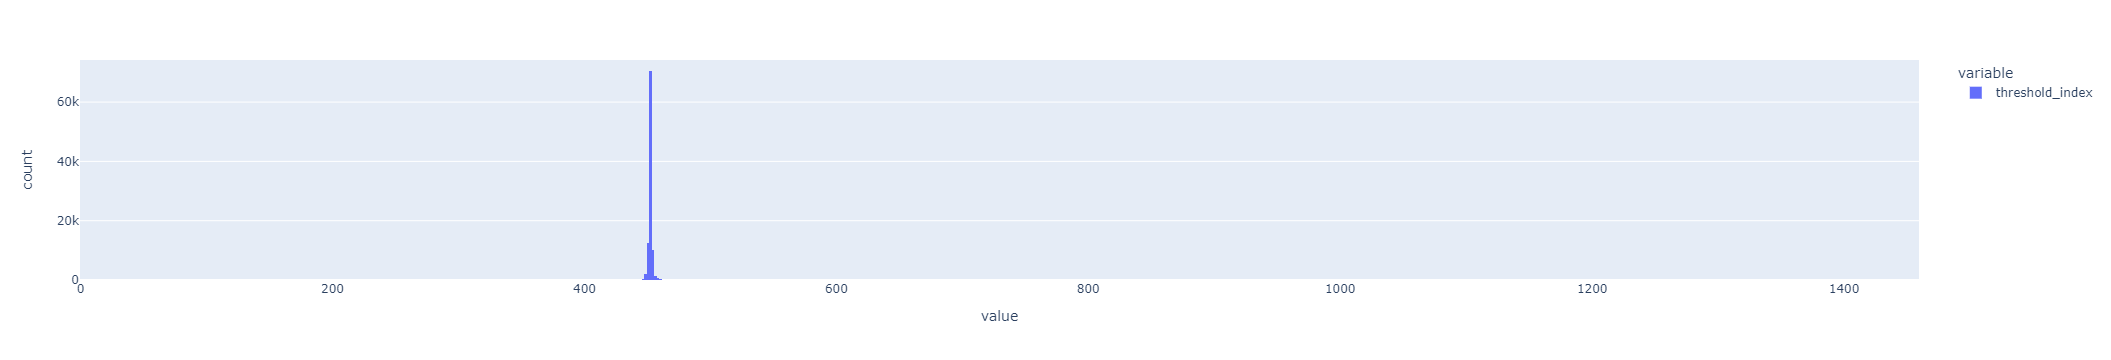

In [17]:
px.histogram(threshold_data['threshold_index'])

In [22]:
index_threshol = threshold_data.query('threshold_index > 550').index.tolist()

In [23]:
start_time = time.time()

for i in index_threshol:
    fig = px.line(run_0.iloc[i][0:5000], title=i)
    pio.write_image(fig, f"{i}.jpeg", format="jpeg")
    
end_time = time.time()
print(end_time - start_time)

62.647316217422485


In [20]:
len(index_threshol)

341

In [36]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [ ]:
px.line(run_0.iloc[616][0:5000], title=2780) 

In [ ]:
threshold_data['threshold_index'].describe()

4899.6865491867065


In [27]:
data_rise

index_start_rise  value_start_rise
0                   362              9852
1                   364              9853
2                   370              9851
3                   364              9851
4                   378              9851
...                 ...               ...
99547               372              9851
99548               374              9858
99549               388              9851
99550               384              9851
99551               388              9853

[99552 rows x 2 columns]

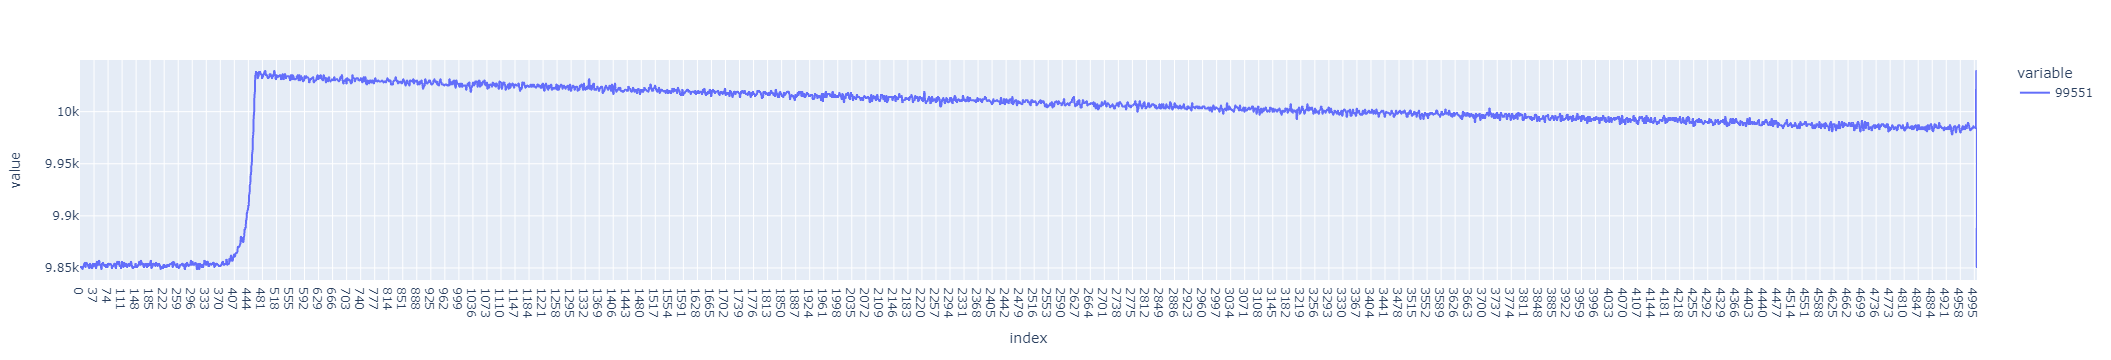

In [30]:
px.line(run_0.iloc[99551])

In [31]:
100000 - 99552

448